In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
%cd /content/drive/MyDrive/GitHub/{repo}

/content/drive/MyDrive/GitHub/reportingAgent


In [ ]:
!git config --global user.name "zbotta"
!git config --global user.email "zbotta@proton.me"
!git pull
!git checkout dev

Already up to date.
M	PoC/PoC-training-MBO.ipynb
M	app/datasets/training/smollm2_360m_onepara_lora/adapter/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/special_tokens_map.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/tokenizer.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/tokenizer_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/trainer_state.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-20/vocab.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/adapter_config.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/special_tokens_map.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/tokenizer.json
D	app/datasets/training/smollm2_360m_onepara_lora/checkpoint-22/tokenizer_config.json
D	app/datasets/training/smollm2_360m_onep

# Testing models < 1B

In [ ]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00


## Qwen 2.5-0.5B-Instruct

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch, re

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, quantization_config=bnb_cfg, device_map="auto",
    torch_dtype=torch.float16, trust_remote_code=True
)

SYSTEM_INSTR = (
  "You are an incident-report generator.\n"
  "Language: {lang_directive}\n"
  "Write ONE SINGLE PARAGRAPH that includes ALL facts provided: what happened, when, where, who, how, why (root cause), and contingency/corrective actions. "
  "Constraints: neutral factual tone; no bullet points, no headings, no lists, no JSON; "
  "do NOT invent details; include only information given; output must be a single line with no line breaks; "
  "preserve numbers, times, names, and proper nouns; limit length to {max_chars} characters."
)

def extract_lang(user_text:str):
    # Optional inline directive, e.g. "Language: French"
    m = re.search(r"(?i)\bLanguage\s*:\s*([A-Za-zÀ-ÿ \-]+)", user_text)
    return m.group(1).strip() if m else None

def build_prompt(user_text, max_chars=400, lang="auto"):
    inline = extract_lang(user_text)
    if inline:
        lang_directive = f"write in {inline}"
    elif lang and lang.lower() != "auto":
        lang_directive = f"write in {lang}"
    else:
        lang_directive = "match the dominant language of the INPUT"

    return (
        SYSTEM_INSTR.format(lang_directive=lang_directive, max_chars=max_chars)
        + "\n\nINPUT:\n" + user_text.strip()
        + f"\n\nOUTPUT (single paragraph, ≤{max_chars} chars):"
    )

def _one_line(s: str) -> str:
    s = s.replace("\n", " ")
    return re.sub(r"\s+", " ", s).strip()

def _clip_paragraph(s: str, max_chars: int) -> str:
    if len(s) <= max_chars: return s
    clipped = s[:max_chars]
    end = max(clipped.rfind("."), clipped.rfind("!"), clipped.rfind("?"))
    return clipped[:end+1] if end > 50 else clipped  # prefer a sentence end

def generate_event_report(user_text, max_chars=400, max_new_tokens=260,
                          temperature=0.0, top_p=1.0, lang="auto"):
    prompt = build_prompt(user_text, max_chars=max_chars, lang=lang)
    messages = [{"role":"user","content":prompt}]
    input_ids = tok.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(model.device)

    out = model.generate(
        input_ids, max_new_tokens=max_new_tokens,
        do_sample=(temperature>0), temperature=temperature, top_p=top_p,
        eos_token_id=tok.eos_token_id
    )
    gen_ids = out[0, input_ids.shape[-1]:]
    text = tok.decode(gen_ids, skip_special_tokens=True)
    text = _one_line(text)
    return _clip_paragraph(text, int(max_chars))




## Tests several languages

As Qwen model is multilingual, we can make a test of the output when the a language directive is done.

This could be interesting to include in the APP deployment.

#### ENGLISH

In [ ]:
# Smoke test (English, auto)
example = """What: Incorrect pH adjustment in buffer preparation
When: June 10, 2025, 9:15 AM
Where: Formulation Area, Production Building 2
Who: Rahul Mehta, Process Technician
How: pH meter not calibrated before use
Why: Technician skipped calibration step due to time pressure
ContingencyActions: Buffer batch discarded, technician retrained, equipment calibration logs reviewed"""
print(generate_event_report(example, lang="auto"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


On June 10, 2025, at 9:15 AM, during the process of preparing a buffer solution for a production batch, an incorrect pH adjustment was made. The pH meter had not been calibrated before its use, leading to an uncontrolled pH level. This oversight occurred after the technician had already started the preparation process without checking the calibration status.


#### FRENCH

In [ ]:
# Smoke test with your 5W1H-style input:
example = """What: Ajustement incorrect du pH lors de la préparation du tampon
When: 10 juin 2025, 9 h 15
Where: Zone de formulation, Bâtiment de production 2
Who: Rahul Mehta, technicien de procédé
How: pH-mètre non étalonné avant utilisation
Why: Le technicien a sauté l’étape d’étalonnage par manque de temps
ContingencyActions : Lot de tampons éliminé, technicien formé à nouveau, journaux d’étalonnage des équipements examinés"""
print(generate_event_report(example, temperature=0.0, lang="FRENCH"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Le pH incorrecte lors de la préparation du tampon a été détecté en juillet 2025, au sein de la zone de formation de la Bâtiment de Production 2, dans le Bâtiment de Production 2. L'ajout de pH-mètres n'était pas effectué avant cette utilisation. Le technicien de procédé, Rahul Mehta, s'est fait sauter l'étape d'étalonnage par manque de temps.


#### SPANISH

In [ ]:
example = """What: Ajuste incorrecto del pH en la preparación de la solución tampón
When: 10 de junio de 2025, 9:15 a. m.
Where: Área de Formulación, Edificio de Producción 2
Who: Rahul Mehta, Técnico de Procesos
How: El medidor de pH no se calibró antes de su uso
Why: El técnico omitió el paso de calibración por falta de tiempo
ContingencyActions : Se descartó el lote de solución tampón, se capacitó al técnico y se revisaron los registros de calibración del equipo"""
print(generate_event_report(example, temperature=0.0, lang="SPANISH"))

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Un ajuste incorrecto del pH en la preparación de la solución tampón ocurrió el 10 de junio de 2025, a las 9:15 a. m., en el área de Formulación del edificio de producción 2. El medidor de pH no se había calibrado antes de su uso. El técnico Rahul Mehta, un técnico de procesos, omitió el paso de calibración por falta de tiempo. La causa fue la falta de tiempo para realizar la calificación correcta.


In [ ]:
!pip install evaluate sentence_transformers numpy bert_score rouge_score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=23294bdcc1c45770cc05ac0f21d137877906e92c73c07d67a150ccd752b633c9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
REF = "On June 10, 2025, at 9:15 AM in the Formulation Area (Production Building 2), technician Rahul Mehta used a non-calibrated pH meter to adjust the buffer, leading to an incorrect pH. The calibration step was skipped due to time pressure. The buffer batch was discarded, Rahul was retrained, and calibration logs were reviewed to prevent recurrence."
PRED = "On June 10, 2025, the buffer preparation process at the Production Building 2 of the Formulation Area encountered an incorrect pH adjustment. The pH meter had not been calibrated before its use, leading to an unadjusted pH value. This oversight resulted in a significant deviation from the desired pH range, causing a critical safety hazard."
PRED2 = "On June 10, 2025, at 9:15 AM, the buffer preparation process for batch number 4667 failed due to incorrect pH adjustment in the buffer preparation area of the production building. The technician, Rahul Mehta, had been tasked with preparing a buffer solution, but he had not performed a pH correction step as per his calibration schedule."
PRED3 = "On June 10, 2025, at 9:15 AM in the production area of Building 2, the buffer preparation team conducted batch #16, a solution containing sodium hydroxide, under the supervision of Master Technician Rahul Mehta, on process control measures. Initially, they expected pH readings within the specified range of 3.8 to 4.3. After checking, they noticed that the pH meters were uncalibrated."
PRED4 = "On June 10, 2025, at 9:15 AM, the buffer preparation process at the Production Building 2 of the Formulation Area encountered an incorrect pH adjustment in the buffer solution. The pH meter had not been calibrated before its use, leading to an uncontrolled pH level. This oversight resulted in a significant deviation from the desired pH range, causing a potential safety hazard."
#at 9:15 AM,
import sys, os
from pathlib import Path
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/app')

from app.mods.metricsEvaluator import MetricsEvaluator

me = MetricsEvaluator()

In [ ]:
me.set_cross_encoder_score(REF, [PRED])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED2])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED3])
print(me.get_cross_encoder_score())
me.set_cross_encoder_score(REF, [PRED4])
print(me.get_cross_encoder_score())

[1.]
[1.]
[1.]
[1.]


In [ ]:
me.set_bi_encoder_score(REF, [PRED], is_test_bench=False)
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED2])
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED3])
print(me.get_bi_encoder_score())
me.set_bi_encoder_score(REF, [PRED4])
print(me.get_bi_encoder_score())

[1.        0.7809284]
[1.         0.73692465]
[1.         0.72478765]
[1.        0.7777794]


In [ ]:
!python -V

Python 3.11.13


In [ ]:
!pip -q install -r requirements_colab.txt
!pip install --upgrade torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.8.0 which is incompatible.


# Grid Search on Tiny Models

## HuggingFaceTB/SmolLM2-360M-Instruct & HuggingFaceTB/SmolLM2-135M-Instruct



In [ ]:
!python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-135M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True & python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

Se han truncado las últimas 5000 líneas del flujo de salida.
{'temperature': 1.3, 'top_p': 0.6, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 34.80it/s]
Batches: 100% 1/1 [00:00<00:00, 65.23it/s]
Ref_row:63 & prompt_method=C: Generating text with the following parameters:
{'temperature': 1.3, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 64.69it/s]
Batches: 100% 1/1 [00:00<00:00, 61.22it/s]
Ref_row:64 & prompt_method=A: Generating text with the following parameters:
{'temperature': 0.3, 'top_p': 0.3, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
08/20/2025 00:44:48 - mods.dataHandler - ERROR - Error while unpacking title or report from model output. Error: 1 validation error for Report
  Invalid JSON: EOF while parsing a string at line 1 column 653 [type=json_invalid, input_value='{"title": "What"

## Qwen/Qwen2.5-0.5B-Instruct

In [ ]:
!python app/reportParamGridSearch.py --model_id Qwen/Qwen2.5-0.5B-Instruct --non-threaded --max_workers  4 --prompt_method B C --dataset_filename pharma_dev_reports_collection.xlsx --start_idx 1 --end_idx 2  --temperature 0.7 1.3 --top_p 0.3 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

2025-08-19 14:55:13.273844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755615313.308470   23223 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755615313.320179   23223 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755615313.348724   23223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755615313.348754   23223 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755615313.348761   23223 computation_placer.cc:177] computation placer alr

In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()

# Training SmolLM2-360M-Instruct


## Plot training loss and metrics function


In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


## Training to minimize eval loss (NLL)

### Generic prompt

In [ ]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" \
  "trl>=0.9.6" peft bitsandbytes evaluate

In [ ]:
!pip -q install wandb

In [ ]:
import os

import wandb
IS_WANDB = False
if IS_WANDB:
  os.environ["WANDB_PROJECT"] = "accident-reporter"
  os.environ["WANDB_WATCH"] = "false"          # don't auto-log gradients
  os.environ["WANDB_SILENT"] = "true"
  from google.colab import userdata
  wand_db_token = userdata.get('wandb_token')
  wandb.login(key=wand_db_token)  # paste token (or set WANDB_API_KEY env var)
else:
  os.environ["WANDB_DISABLED"] = "true"

In [55]:
# === ONE-CELL QLoRA TRAINER: SmolLM2-360M-Instruct with trl.SFTConfig (no char clipping) ===
# Colab tip: Runtime -> Change runtime type -> GPU (T4)

import os, re, json, torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

MODEL_ID = "HuggingFaceTB/SmolLM2-360M-Instruct"
TRAINING_DIR = "app/datasets/training"
OUT_DIR  = TRAINING_DIR + "/smollm2_360m_onepara_lora"

# 4-bit QLoRA base (tiny VRAM/RAM footprint)
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False  # needed for grad checkpointing
# LoRA config (light but effective for ~500 rows)

# -------- Autodetect LoRA target modules (robust across archs) --------
def guess_lora_targets(m):
    names = set()
    for n, mod in m.named_modules():
        if isinstance(mod, torch.nn.Linear):
            names.add(n.split(".")[-1])
    # Prefer common llama/mistral-ish names if present
    preferred = [x for x in ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
                              "wi","wo","wq","wk","wv","out_proj","fc_in","fc_out"] if x in names]
    if preferred:
        return preferred
    # Fallback: all linear leaf names except lm_head
    return sorted(list({n for n in names if n != "lm_head"}))

target_modules = guess_lora_targets(model)
if not target_modules:
    raise RuntimeError("Could not find any target modules for LoRA — aborting to avoid no-grad training.")

# --- Load LoRa config  ---

peft_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM"
)
model_lora_check = get_peft_model(model, peft_cfg)
model_lora_check.print_trainable_parameters()

ds = load_dataset("json", data_files={"train":TRAINING_DIR+"/train.jsonl","eval":TRAINING_DIR+"/eval.jsonl"})

print(f"DS_1: {ds}")


def one_line(s: str) -> str:
    s = str(s).replace("\n"," ")
    return re.sub(r"\s+"," ", s).strip()

INSTR = (
  "Write ONE SINGLE PARAGRAPH in English that includes ALL given facts: what happened, when, where, who, how, why "
  "(root cause), and contingency/corrective actions. Neutral tone. No bullet points, no headings, no lists, no JSON. "
  "DO NOT invent details. Output must be a single line (no line breaks)."
)
RESP_TMPL = "### Response:\n"  # SFTTrainer will mask everything before this marker as prompt
MAX_LEN = 1024

def find_subsequence(xs: list[int], ys: list[int]) -> int:
    """Return start index of ys inside xs, or -1 if not found."""
    n, m = len(xs), len(ys)
    if m == 0 or m > n: return -1
    for i in range(n - m + 1):
        if xs[i:i+m] == ys:
            return i
    return -1

def tokenize_and_mask(example: dict) -> dict:
    # Build full prompt -> "### Instruction ... INPUT ... ### Response:\n + target"
    text_in  = one_line(example["input"])
    text_out = one_line(example["target"])
    full = f"### Instruction:\n{INSTR}\n\nINPUT:\n{text_in}\n\n{RESP_TMPL}{text_out}"

    enc = tok(
        full,
        truncation=True,
        max_length=MAX_LEN,
        padding=False,             # pad later in collator
        return_tensors=None
    )
    input_ids = enc["input_ids"]
    labels    = input_ids.copy()

    # Locate response template and mask everything before the end of it
    rt_ids = tok(RESP_TMPL, add_special_tokens=False)["input_ids"]
    start = find_subsequence(input_ids, rt_ids)
    if start == -1:
        # If marker not found (rare after truncation), skip supervision on whole sample
        labels[:] = [-100] * len(labels)
    else:
        # Mask up to the end of the template tokens
        cut = start + len(rt_ids)
        labels[:cut] = [-100] * cut

    return {
        "input_ids": input_ids,
        "attention_mask": enc["attention_mask"],
        "labels": labels
    }

ds_tok = ds.map(tokenize_and_mask, remove_columns=ds["train"].column_names, desc="Tokenizing & masking")

# print(f"DS_2: {ds_tok}")

ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

# Make sure the dataset yields torch tensors with those keys
ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
# print(f"DS_3: {ds_tok}")

# Simple collator: pad inputs and labels to max length in batch
class CausalLMPadCollator:
    def __init__(self, tokenizer, label_pad_id=-100):
        self.tok = tokenizer
        self.label_pad_id = label_pad_id

    def __call__(self, features: list[dict]) -> dict[str, torch.Tensor]:
        max_len = max(len(f["input_ids"]) for f in features)
        input_ids, attn, labels = [], [], []
        for f in features:
            pad = max_len - len(f["input_ids"])
            input_ids.append(f["input_ids"] + [self.tok.pad_token_id] * pad)
            attn.append(f["attention_mask"] + [0] * pad)
            labels.append(f["labels"] + [self.label_pad_id] * pad)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

collator = CausalLMPadCollator(tok)

# --- SFTConfig (replaces TrainingArguments) ---
sft_cfg = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=4,                       # 2 epochs is plenty for ~500 rows
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,           # eff batch ~= 64
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    learning_rate=1.5e-4,
    lr_scheduler_type="cosine",
    warmup_steps=3,
    load_best_model_at_end=True,
    # warmup_ratio = 0.03, # not a good idea if our data is short
    eval_strategy="epoch", # "steps"
    # eval_steps=100,
    save_strategy="epoch", # "steps"
    # save_steps=100,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    logging_steps=1,
    fp16=True,                                # T4-friendly
    optim="paged_adamw_8bit",
    max_grad_norm=0.5,
    max_length = MAX_LEN,                      # handled by SFTTrainer when set here
    # dataset_text_field="text", # Removed as data is already tokenized
    packing=False,
    remove_unused_columns=False,           # important for pre-tokenized inputs
    report_to="none"  # wandb
)

trainer = SFTTrainer(
    model=model,
    args=sft_cfg,                             # <-- using SFTConfig
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    train_dataset=ds_tok["train"], # Use the tokenized dataset
    eval_dataset=ds_tok["eval"],   # Use the tokenized dataset
    data_collator = collator,
    peft_config=peft_cfg,
)
trainer.train()
final_metrics = trainer.evaluate()      # logs eval_loss into state.log_history
print("Final eval:", final_metrics)

# Save LoRA adapter
adapter_dir = f"{OUT_DIR}/adapter"
trainer.model.save_pretrained(adapter_dir)
tok.save_pretrained(adapter_dir)
print("Saved LoRA adapter to:", adapter_dir)

# ---------------------- Inference (no char clipping) ----------------------
# @torch.no_grad()
# def build_infer_prompt(user_text: str) -> str:
#     return "### Instruction:\n" + INSTR + "\n\nINPUT:\n" + one_line(user_text) + f"\n\n{RESP_TMPL}"

# @torch.no_grad()
# def generate_one_paragraph(user_text: str, max_new_tokens: int = 220,
#                            temperature: float = 0.0, top_p: float = 1.0) -> str:
#     prompt = build_infer_prompt(user_text)
#     ids = tok(prompt, return_tensors="pt").to(trainer.model.device)
#     out = trainer.model.generate(
#         **ids,
#         max_new_tokens=max_new_tokens,
#         do_sample=(temperature>0),
#         temperature=temperature,
#         top_p=top_p,
#         eos_token_id=tok.eos_token_id
#     )
#     gen = tok.decode(out[0], skip_special_tokens=True).split(RESP_TMPL, 1)[-1]
#     return one_line(gen)  # single line, but no length clipping

# # Quick check on a couple eval samples
# eval_split = load_dataset("json", data_files={"eval":TRAINING_DIR+"/eval.jsonl"})["eval"] # Load from the correct directory
# for i in range(min(3, len(eval_split))):
#     print("-", generate_one_paragraph(eval_split[i]["input"]))

# Log metrics in wandb
# wandb.log({
#   "eval/paragraphness": no_breaks / N,      # % with no '\n'
#   "eval/<=400_chars": within_len / N,
#   "eval/slot_coverage": slot_cov,           # if you compute it
# })
# del meval

plot_training_results(OUT_DIR,trainer)

trainable params: 4,341,760 || all params: 366,162,880 || trainable%: 1.1857
DS_1: DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 699
    })
    eval: Dataset({
        features: ['input', 'target'],
        num_rows: 70
    })
})


Tokenizing & masking:   0%|          | 0/699 [00:00<?, ? examples/s]

Tokenizing & masking:   0%|          | 0/70 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/699 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Prompt with demo (prompt D as ref)


In [3]:
!pip -q install -U "transformers>=4.43" "accelerate>=0.33" "datasets>=2.20" peft bitsandbytes trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 12.1 MB/s eta 0:00:00


#### Load training function and plot function

In [69]:
# ==== ONE-CELL COLAB: wrap QLoRA + demo-prompt SFT into a function that returns the trainer ====
# Colab: Runtime > Change runtime type > GPU (T4)
import os, re, numpy as np, torch
from dataclasses import dataclass
from typing import Dict, List, Tuple
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer, SFTConfig

import matplotlib.pyplot as plt
import pandas as pd

# =========================
# Post-training: PNG GRAPHS + CSV
# =========================

def plot_training_results(out_dir, _trainer):
  """ loads trainer log history and plots results and exports images """
  logs = pd.DataFrame(_trainer.state.log_history)
  if logs.empty:
      print("No logs recorded. Did logging_steps/eval_steps run?")
  else:
      os.makedirs(out_dir, exist_ok=True)
      log_csv = os.path.join(out_dir, "training_logs.csv")
      logs.to_csv(log_csv, index=False)
      print("Saved raw logs to:", log_csv)

      def safe_exp(x):
          try: return float(np.exp(x))
          except Exception: return np.nan

      train_df = logs[logs["loss"].notna()][["step","loss"]].copy()
      eval_df  = logs[logs["eval_loss"].notna()][["step","eval_loss"]].copy()
      lr_df    = logs[logs["learning_rate"].notna()][["step","learning_rate"]].copy()

      if not eval_df.empty: eval_df["eval_perplexity"] = eval_df["eval_loss"].map(safe_exp)
      if not train_df.empty: train_df["perplexity"] = train_df["loss"].map(safe_exp)

      def smooth(y, k=5):
          s = pd.Series(y); return s.rolling(k, min_periods=1, center=True).mean().values

      if not train_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(train_df["step"], train_df["loss"], label="train loss")
          plt.plot(train_df["step"], smooth(train_df["loss"], 7), label="train loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Training Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "train_loss.png")); plt.show()

      if not eval_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_loss"], label="eval loss")
          plt.plot(eval_df["step"], smooth(eval_df["eval_loss"], 3), label="eval loss (smoothed)")
          plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Eval Loss")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_loss.png")); plt.show()

          plt.figure(figsize=(7,4))
          plt.plot(eval_df["step"], eval_df["eval_perplexity"], label="eval perplexity")
          plt.xlabel("Step"); plt.ylabel("Perplexity"); plt.title("Eval Perplexity")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "eval_perplexity.png")); plt.show()

      if not lr_df.empty:
          plt.figure(figsize=(7,4))
          plt.plot(lr_df["step"], lr_df["learning_rate"], label="learning rate")
          plt.xlabel("Step"); plt.ylabel("LR"); plt.title("Learning Rate Schedule")
          plt.legend(); plt.tight_layout()
          plt.savefig(os.path.join(out_dir, "learning_rate.png")); plt.show()

      if not eval_df.empty:
          best_row = eval_df.loc[eval_df["eval_loss"].idxmin()]
          print(f"Best eval loss: {best_row['eval_loss']:.4f} at step {int(best_row['step'])} "
                f"(perplexity ~ {best_row['eval_perplexity']:.2f})")
      if not train_df.empty:
          print(f"Final train loss: {train_df['loss'].iloc[-1]:.4f} at step {int(train_df['step'].iloc[-1])}")


def train_demo_qlora(
    MODEL_ID: str = "HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR: str = "smollm2_demo_qlora",
    DEMO_PROB: float = 1.0,
    DATASET_ID = "zBotta/traffic-accidents-reports-800",
    sft_cfg: SFTConfig,
):
    """
    Fine-tune MODEL_ID with QLoRA on DATASET_ID using a demo-wired prompt.
    Dataset format: splits 'train' and 'eval', each row has:
      - 'input': string "What: ..., When: ..., Where: ..., Who: ..., How: ..., Why: ..., ContingencyActions: ..."
      - 'target': one-paragraph report (string)
    Returns: SFTTrainer (trained)
    """
    MAX_LEN   = 1024
    RESP_TMPL = "### Response:\n"
    INSTR = (
      """
      You are a reporting agent.
      You task is to create a report when provided the what, when, why, who, how and where questions about the events.
      You are also given information about the contingency actions regarding the event.

      Guidelines:
      - Generate only one report given the informations about the event
      - Generate the report as text in one paragraph
      - It is important to focus on accuracy and coherence when generating the report so that the description content matches the information provided (what, when, where, who, how , why, contingency actions).
        If an information is not provided in (what, when, where, who, how , why, contingency actions), it must not be part of the generated text description.
      """
    )

    def one_line(s: str) -> str:
        return re.sub(r"\s+"," ", str(s).replace("\n"," ")).strip()

    # ---- Load dataset (must have train/eval with 'input' and 'target') ----
    raw_any = load_dataset(DATASET_ID)
    assert "train" in raw_any and "eval" in raw_any, "Dataset must have 'train' and 'eval' splits."
    ds_raw = DatasetDict(train=raw_any["train"], eval=raw_any["eval"])

    print(f"train len before validation: {len(ds_raw['train'])}")
    print(f"eval  len before validation: {len(ds_raw['eval'])}")

    def valid_row(rec: Dict) -> bool:
        return bool(str(rec.get("input","")).strip()) and bool(str(rec.get("target","")).strip())

    ds_raw = DatasetDict(
        train=ds_raw["train"].filter(valid_row),
        eval =ds_raw["eval"].filter(valid_row)
    )

    print(f"train len after validation: {len(ds_raw['train'])}")
    print(f"eval  len after validation: {len(ds_raw['eval'])}")

    # Build demo pool from TRAIN
    demo_pool: List[Tuple[str,str]] = [(one_line(ex["input"]), one_line(ex["target"])) for ex in ds_raw["train"]]

    # ---- Prompt builders ----
    def build_prompt_with_demo(demo_in: str, demo_out: str, current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input-example:\n" + demo_in + "\n\n" +
            "### Output-example:\n" + one_line(demo_out) + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

    def build_prompt_no_demo(current_in: str) -> str:
        return (
            "### Instruction:\n" + INSTR + "\n\n" +
            "### Input:\n" + current_in + "\n\n" +
            RESP_TMPL
        )

# ------------------ Tokenizer ------------------
    tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
    if tok.pad_token_id is None: tok.pad_token = tok.eos_token

    # Map rows -> prompt first (kept), then target fills the remaining budget
    def add_demo_and_tokenize(example, idx):
        cur_in  = one_line(example["input"])
        cur_out = one_line(example["target"])

        use_demo = (np.random.rand() < DEMO_PROB) and (len(demo_pool) > 1)
        if use_demo:
            demo_idx = (idx + 1) % len(demo_pool)  # simple different row
            demo_in, demo_out = demo_pool[demo_idx]
            prompt = build_prompt_with_demo(demo_in, demo_out, cur_in)
        else:
            prompt = build_prompt_no_demo(cur_in)

        # 1) tokenize prompt first (so the response marker is always inside)
        prom = tok(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
        prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # If prompt alone overflows, fall back to no-demo minimal prompt
        if len(prompt_ids) >= MAX_LEN - 4:
            prompt = prompt_no_demo(cur_in)
            prom = tok(prompt, add_special_tokens=True, truncation=True, max_length=MAX_LEN, padding=False)
            prompt_ids = prom["input_ids"]; attn_prompt = prom["attention_mask"]

        # 2) tokenize target to fill remaining budget
        budget = MAX_LEN - len(prompt_ids)
        targ = tok(cur_out, add_special_tokens=False, truncation=True, max_length=max(1, budget), padding=False)
        target_ids = targ["input_ids"][:max(0, budget)]

        # assemble & ensure ≥1 supervised token
        input_ids = prompt_ids + target_ids
        attention_mask = attn_prompt + [1]*len(target_ids)
        labels = [-100]*len(prompt_ids) + target_ids
        if not target_ids:  # ensure graph has grad
            eos = tok.eos_token_id
            input_ids += [eos]; attention_mask += [1]; labels += [eos]

        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


    ds_tok = ds_raw.map(
        add_demo_and_tokenize,
        with_indices=True,
        remove_columns=ds_raw["train"].column_names,
        desc="Building demo prompts + tokenizing"
    )

    ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

    # Make sure the dataset yields torch tensors with those keys
    ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

    # ---- QLoRA base model ----
    bnb4 = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.float16
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb4,
        torch_dtype=torch.float16,
        device_map="auto",
    )
    model.config.use_cache = False  # better with gradient checkpointing

    # LoRA adapters

    # -------- Autodetect LoRA target modules (robust across archs) --------
    def guess_lora_targets(m):
        names = set()
        for n, mod in m.named_modules():
            if isinstance(mod, torch.nn.Linear):
                names.add(n.split(".")[-1])
        # Prefer common llama/mistral-ish names if present
        preferred = [x for x in ["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj",
                                 "wi","wo","wq","wk","wv","out_proj","fc_in","fc_out"] if x in names]
        if preferred:
            return preferred
        # Fallback: all linear leaf names except lm_head
        return sorted(list({n for n in names if n != "lm_head"}))

    target_modules = guess_lora_targets(model)
    if not target_modules:
        raise RuntimeError("Could not find any target modules for LoRA — aborting to avoid no-grad training.")

    # --- Load LoRa config  ---

    lora_cfg = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.05,
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
        task_type="CAUSAL_LM"
    )
    model_lora_check = get_peft_model(model, lora_cfg)
    model_lora_check.print_trainable_parameters()

    # ---- Collator ----
    @dataclass
    class CausalLMPadCollator:
        pad_id: int
        def __call__(self, feats: List[Dict]):
            maxlen = max(len(f["input_ids"]) for f in feats)
            def pad(seq, v): return seq + [v]*(maxlen-len(seq))
            return {
                "input_ids": torch.tensor([pad(f["input_ids"], self.pad_id) for f in feats]),
                "attention_mask": torch.tensor([pad(f["attention_mask"], 0) for f in feats]),
                "labels": torch.tensor([pad(f["labels"], -100) for f in feats]),
            }
    collator = CausalLMPadCollator(tok.pad_token_id)

    # ---- Trainer (TRL SFT) ----


    trainer = SFTTrainer(
        model=model,
        args=sft_cfg,
        peft_config=lora_cfg,
        train_dataset=ds_tok["train"],
        eval_dataset=ds_tok["eval"],
        data_collator=collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    )

    trainer.train()

    # Save LoRA adapter
    adapter_dir = f"{OUT_DIR}/adapter"
    os.makedirs(adapter_dir, exist_ok=True)
    model.save_pretrained(adapter_dir)
    tok.save_pretrained(adapter_dir)
    print("Saved LoRA adapter to:", adapter_dir)

    # Try to merge for standalone export (may be unsupported with 4-bit base in some envs)
    try:
        merged = trainer.model.merge_and_unload()
        merged_dir = f"{OUT_DIR}/merged"
        os.makedirs(merged_dir, exist_ok=True)
        merged.save_pretrained(merged_dir, safe_serialization=True)
        tok.save_pretrained(merged_dir)
        print("Merged model saved to:", merged_dir)
    except Exception as e:
        print("Skip merging (common with 4-bit base):", e)

    return trainer

# --- Example usage (uncomment to run) ---
# trainer = train_demo_qlora(
#     MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
#     OUT_DIR="smollm2_360m_demo_qlora",
#     DEMO_PROB=1.0
# )


#### Execute function with given model training ID - 800 rows

README.md: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/629 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/70 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

train len before validation: 629
eval  len before validation: 70


Filter:   0%|          | 0/629 [00:00<?, ? examples/s]

Filter:   0%|          | 0/70 [00:00<?, ? examples/s]

train len after validation: 629
eval  len after validation: 70


Building demo prompts + tokenizing:   0%|          | 0/629 [00:00<?, ? examples/s]

Building demo prompts + tokenizing:   0%|          | 0/70 [00:00<?, ? examples/s]

trainable params: 4,341,760 || all params: 366,162,880 || trainable%: 1.1857


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Truncating train dataset:   0%|          | 0/629 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.330900,1.313430
2,1.197100,1.208333
3,1.131600,1.125862
4,1.053300,1.066727
5,1.021300,1.027761
6,0.970400,1.003372
7,0.935400,0.984088
8,0.940100,0.971106
9,0.915400,0.961902
10,0.885500,0.955039


Saved LoRA adapter to: app/datasets/training/smollm2_360m_demo_1para_qlora/adapter


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Merged model saved to: app/datasets/training/smollm2_360m_demo_1para_qlora/merged
Saved raw logs to: app/datasets/training/smollm2_360m_demo_1para_qlora/training_logs.csv


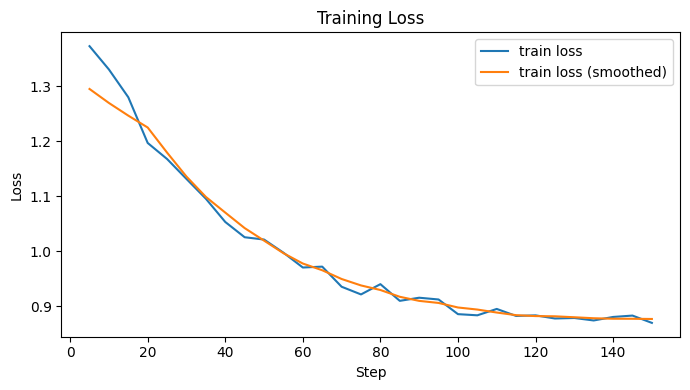

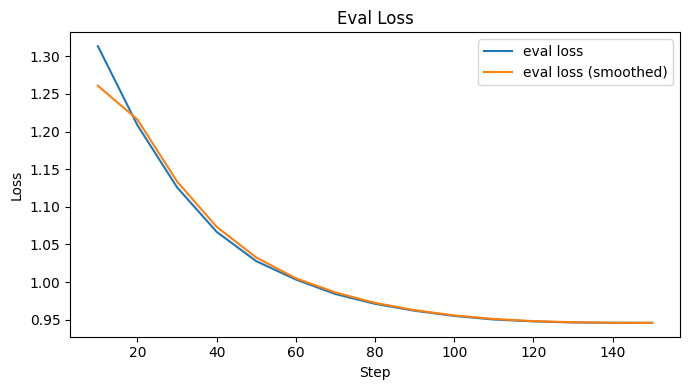

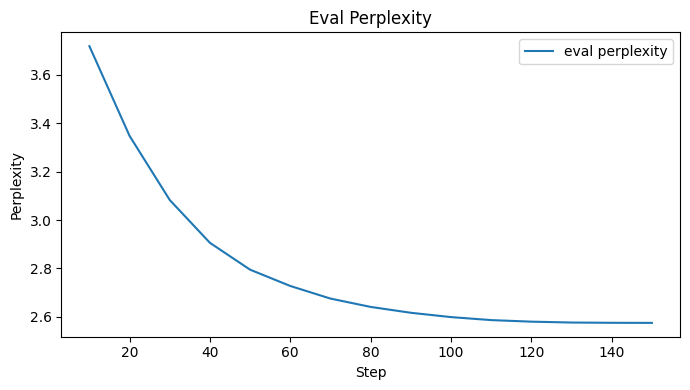

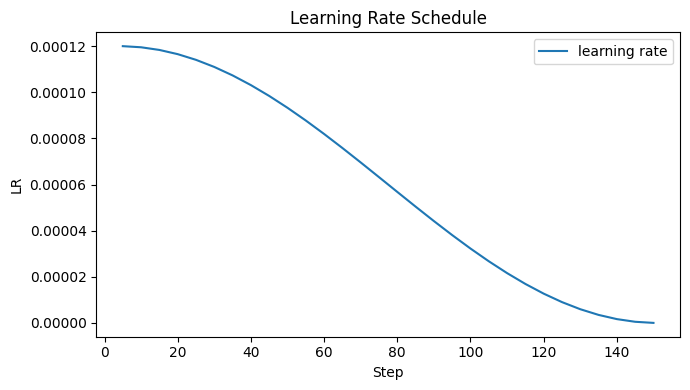

Best eval loss: 0.9458 at step 150 (perplexity ~ 2.57)
Final train loss: 0.8696 at step 150


In [70]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_360m_demo_1para_qlora"

sft_cfg = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,                    # 2–3 usually enough
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,        # eff batch ~64
    learning_rate=1.2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=3,                        # explicit small warmup for tiny runs
    logging_steps=5,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    optim="paged_adamw_8bit",
    max_length=MAX_LEN,
    remove_unused_columns=False,           # keep tokenized fields
    report_to="none", #wandb
)

trainer = train_demo_qlora(
    MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-800",
    sft_cfg=sft_cfg,
)
plot_training_results(out_dir,trainer)

#### Push trained model to HF

In [72]:
repo_id = "zBotta/smollm2-accident-reporter-360m"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged"
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
# api.create_repo(repo_id, private=False, repo_type="model")
upload_folder(folder_path=merged_dir, repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...para_qlora/merged/model.safetensors:  14%|#4        | 50.3MB /  352MB            

Pushed: zBotta/smollm2-accident-reporter-360m


#### Execute function with given model training ID - 5k rows

In [ ]:
# Login to HG to download dataset and push trained model
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get('hf_token')
login(token=hf_token)

TRAINING_DIR = "app/datasets/training"
out_dir  = TRAINING_DIR + "/smollm2_360m_demo_1para_qlora_5k"

trainer = train_demo_qlora(
    MODEL_ID="HuggingFaceTB/SmolLM2-360M-Instruct",
    OUT_DIR=out_dir,
    DEMO_PROB=1.0,
    DATASET_ID="zBotta/traffic-accidents-reports-5k",
    EPOCHS=15,
)
plot_training_results(out_dir,trainer)

#### Push trained model to HF

In [ ]:
repo_id = "zBotta/smollm2-accident-reporter-360m-5k"

from huggingface_hub import HfApi, create_repo, upload_folder, login
merged_dir = f"{out_dir}/merged"
from google.colab import userdata
hf_token = userdata.get('hf_token')

login(token=hf_token)

api = HfApi(token=hf_token)
# api.create_repo(repo_id, private=False, repo_type="model")
upload_folder(folder_path=merged_dir repo_id=repo_id, repo_type="model")
print("Pushed:", repo_id)

### Free up VRAM

In [68]:
# Free VRAM after training (safe cleanup)
import gc, torch

def free_vram(trainer=None, *extra_objs):
    # 1) ask Accelerate to release buffers (if present)
    try:
        if trainer is not None and hasattr(trainer, "accelerator"):
            trainer.accelerator.wait_for_everyone()
            trainer.accelerator.free_memory()
    except Exception as e:
        print("accelerator.free_memory() skipped:", e)

    # 2) move big models to CPU so CUDA refs can drop
    for obj in (trainer,)+extra_objs if trainer is not None else extra_objs:
        try:
            m = getattr(obj, "model", None) or obj
            if hasattr(m, "to"):
                m.to("cpu")
        except Exception:
            pass

    # 3) drop strong references
    for name in list(globals().keys()):
        # keep notebook/system internals
        if name.startswith(("__", "_", "In", "Out")):
            continue
        try:
            val = globals()[name]
            if hasattr(val, "to") or hasattr(val, "parameters"):  # models, trainers, tokenizers (sometimes hold buffers)
                globals()[name] = None
        except Exception:
            pass

    # 4) garbage-collect Python objects and release CUDA caches
    gc.collect()
    try:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()
    except Exception:
        pass

# Delete trainer data
free_vram(trainer)                   # if you only have the trainer


NameError: name 'merged' is not defined

## Testing ce_sim/be_sim as metric for training

We are going to:
- use the existing **MetricsEvaluator** class
- Create a compute_metrics function to calculate be_sim and ce_sim on each generated text at the end of the epoch
- **NOTA**: It is really slow, we are going to keep with loss eval



In [ ]:
!pip -q install sentence_transformers bert-score evaluate rouge_score

In [ ]:
pred = "On June 10, 2025, at 9:15 AM in the Formulation Area (Production Building 2), technician Rahul Mehta used a non-calibrated pH meter to adjust the buffer, leading to an incorrect pH."
ref = "In the Formulation Area I had a problem with the ph"
meval.set_cross_encoder_score(ref, [pred], )
print(meval.get_cross_encoder_score())

[0.3631974 1.0000001 0.3631974]


In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np
import re
from app.mods.metricsEvaluator import MetricsEvaluator

meval = MetricsEvaluator()

#### Training for maximizing be_sim

In [ ]:
# === ONE-CELL QLoRA TRAINER: SmolLM2-360M-Instruct with trl.SFTConfig (no char clipping) ===
# Colab tip: Runtime -> Change runtime type -> GPU (T4)

import os, re, json, torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, EarlyStoppingCallback
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig

MODEL_ID = "HuggingFaceTB/SmolLM2-360M-Instruct"
TRAINING_DIR = "app/datasets/training"
OUT_DIR  = TRAINING_DIR + "/smollm2_360m_onepara_lora"

# 4-bit QLoRA base (tiny VRAM/RAM footprint)
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
if tok.pad_token_id is None:
    tok.pad_token = tok.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb,
    torch_dtype=torch.float16,
    device_map="auto",
)
model.config.use_cache = False  # needed for grad checkpointing

# LoRA config (light but effective for ~500 rows)
peft_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    task_type="CAUSAL_LM"
)

ds = load_dataset("json", data_files={"train":TRAINING_DIR+"/train.jsonl","eval":TRAINING_DIR+"/eval.jsonl"})

print(f"DS_1: {ds}")


def one_line(s: str) -> str:
    s = str(s).replace("\n"," ")
    return re.sub(r"\s+"," ", s).strip()

INSTR = (
  "Write ONE SINGLE PARAGRAPH in English that includes ALL given facts: what happened, when, where, who, how, why "
  "(root cause), and contingency/corrective actions. Neutral tone. No bullet points, no headings, no lists, no JSON. "
  "DO NOT invent details. Output must be a single line (no line breaks)."
)
RESP_TMPL = "### Response:\n"  # SFTTrainer will mask everything before this marker as prompt
MAX_LEN = 1024

def find_subsequence(xs: list[int], ys: list[int]) -> int:
    """Return start index of ys inside xs, or -1 if not found."""
    n, m = len(xs), len(ys)
    if m == 0 or m > n: return -1
    for i in range(n - m + 1):
        if xs[i:i+m] == ys:
            return i
    return -1

def tokenize_and_mask(example: dict) -> dict:
    # Build full prompt -> "### Instruction ... INPUT ... ### Response:\n + target"
    text_in  = one_line(example["input"])
    text_out = one_line(example["target"])
    full = f"### Instruction:\n{INSTR}\n\nINPUT:\n{text_in}\n\n{RESP_TMPL}{text_out}"

    enc = tok(
        full,
        truncation=True,
        max_length=MAX_LEN,
        padding=False,             # pad later in collator
        return_tensors=None
    )
    input_ids = enc["input_ids"]
    labels    = input_ids.copy()

    # Locate response template and mask everything before the end of it
    rt_ids = tok(RESP_TMPL, add_special_tokens=False)["input_ids"]
    start = find_subsequence(input_ids, rt_ids)
    if start == -1:
        # If marker not found (rare after truncation), skip supervision on whole sample
        labels[:] = [-100] * len(labels)
    else:
        # Mask up to the end of the template tokens
        cut = start + len(rt_ids)
        labels[:cut] = [-100] * cut

    return {
        "input_ids": input_ids,
        "attention_mask": enc["attention_mask"],
        "labels": labels
    }

ds_tok = ds.map(tokenize_and_mask, remove_columns=ds["train"].column_names, desc="Tokenizing & masking")

# print(f"DS_2: {ds_tok}")

ds_tok = ds_tok.remove_columns([c for c in ds_tok["train"].column_names
                                if c not in ("input_ids","attention_mask","labels")])

# Make sure the dataset yields torch tensors with those keys
ds_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
# print(f"DS_3: {ds_tok}")

# Simple collator: pad inputs and labels to max length in batch
class CausalLMPadCollator:
    def __init__(self, tokenizer, label_pad_id=-100):
        self.tok = tokenizer
        self.label_pad_id = label_pad_id

    def __call__(self, features: list[dict]) -> dict[str, torch.Tensor]:
        max_len = max(len(f["input_ids"]) for f in features)
        input_ids, attn, labels = [], [], []
        for f in features:
            pad = max_len - len(f["input_ids"])
            input_ids.append(f["input_ids"] + [self.tok.pad_token_id] * pad)
            attn.append(f["attention_mask"] + [0] * pad)
            labels.append(f["labels"] + [self.label_pad_id] * pad)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attn, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

collator = CausalLMPadCollator(tok)


# Keep raw targets so compute_metrics can use them
eval_ref_texts = [one_line(ex["target"]) for ex in ds["eval"]]  # BEFORE tokenization

def make_compute_ce_sim(meval: MetricsEvaluator,
                        tokenizer,
                        eval_ref_texts,
                        use_be: bool = True,     # compute bi-encoder similarity
                        use_ce: bool = False,    # compute cross-encoder similarity (slower)
                        max_new_tokens=300,
                        batch_size=8):
    @torch.inference_mode()
    def compute_ce_sim(_eval_pred):  # ignore logits; we generate here
        model.eval()
        preds = []
        # Need to regenerate text from input prompts, not decode raw predictions which may have -100s
        # The prompt needs to be built from the original input text, not the tokenized version.
        # Get the original input texts from the evaluation dataset
        refs = [ex["input"] for ex in ds["eval"]]

        for i in range(0, len(refs), batch_size):
            batch_inputs = refs[i:i+batch_size]
            prompts = [f"### Instruction:\n{INSTR}\n\nINPUT:\n{one_line(inp)}\n\n{RESP_TMPL}"
                       for inp in batch_inputs]

            ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
            out = model.generate(**ids, max_new_tokens=max_new_tokens, do_sample=False,
                                 eos_token_id=tokenizer.eos_token_id)
            texts = tokenizer.batch_decode(out, skip_special_tokens=True)
            preds.extend([one_line(t.split(RESP_TMPL,1)[-1]) for t in texts])

        ce_vals, be_vals = [], []
        if use_be:
          for ref, pred in zip(refs, preds):
              # compare_all_texts=False → only ref↔pred; is_test_bench=True → drop ref↔ref
              meval.set_bi_encoder_score(ref, [pred], compare_all_texts=False, is_test_bench=True)
              be = meval.get_bi_encoder_score()
              be_vals.append(float(np.asarray(be).reshape(-1)[0]))

        if use_ce:
            for ref, pred in zip(refs, preds):
                meval.set_cross_encoder_score(ref, [pred])
                ce = meval.get_cross_encoder_score()
                ce_vals.append(float(np.asarray(ce).reshape(-1)[0]))

        # score in small batches to save memory
        # scores = []
        # for p, r in zip(preds, eval_ref_texts):
        #     meval.set_cross_encoder_score(r, [p])
        #     score = float(meval.get_cross_encoder_score()[0]) # Corrected: get the scalar score
        #     scores.append(score)
        # return {"ce_sim": float(np.mean(scores)),
        #         "ce_sim_std": float(np.std(scores))}

        metrics = {}
        if use_be:
            metrics["be_sim_mean"] = float(np.mean(be_vals)) if be_vals else 0.0
            metrics["be_sim_std"]  = float(np.std(be_vals))  if be_vals else 0.0
        if use_ce:
            metrics["ce_sim_mean"] = float(np.mean(ce_vals)) if ce_vals else 0.0
            metrics["ce_sim_std"]  = float(np.std(ce_vals))  if ce_vals else 0.0
        return metrics
    return compute_ce_sim

compute_metrics = make_compute_ce_sim(meval, tok, eval_ref_texts, batch_size=4)

# --- SFTConfig (replaces TrainingArguments) ---
sft_cfg = SFTConfig(
    output_dir=OUT_DIR,
    num_train_epochs=4,                       # 2 epochs is plenty for ~500 rows
    per_device_train_batch_size=4,
    gradient_accumulation_steps=16,           # eff batch ~= 64
    gradient_checkpointing=False,             #Turn off checkpointing (needs a bit more VRAM on T4, but SmolLM2-360M QLoRA usually fits):
    learning_rate=1.5e-4,
    lr_scheduler_type="cosine",
    warmup_steps=3,
    eval_strategy="epoch", # "steps"
    save_strategy="epoch", # "steps"
    metric_for_best_model= "be_sim_mean",#"ce_sim",  # Cross-encoding similarity
    greater_is_better=True,   # Maximize metric
    save_total_limit=2,
    logging_steps=1,
    fp16=True,                                # T4-friendly
    optim="paged_adamw_8bit",
    max_grad_norm=0.5,
    max_length =MAX_LEN,                      # handled by SFTTrainer when set here
    packing=False,
    remove_unused_columns=False,           # important for pre-tokenized inputs
    report_to="none"  # wandb
)

trainer = SFTTrainer(
    model=model,
    args=sft_cfg,                             # <-- using SFTConfig
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
    train_dataset=ds_tok["train"], # Use the tokenized dataset
    eval_dataset=ds_tok["eval"],   # Use the tokenized dataset
    data_collator = collator,
    peft_config=peft_cfg,
    compute_metrics=compute_metrics, # custom ce_sim and be_sim
)
trainer.train()
final_metrics = trainer.evaluate()      # logs eval_loss into state.log_history
print("Final eval:", final_metrics)

# Save LoRA adapter
adapter_dir = f"{OUT_DIR}/adapter"
trainer.model.save_pretrained(adapter_dir)
tok.save_pretrained(adapter_dir)
print("Saved LoRA adapter to:", adapter_dir)

DS_1: DatasetDict({
    train: Dataset({
        features: ['input', 'target'],
        num_rows: 699
    })
    eval: Dataset({
        features: ['input', 'target'],
        num_rows: 70
    })
})


Tokenizing & masking:   0%|          | 0/699 [00:00<?, ? examples/s]

Tokenizing & masking:   0%|          | 0/70 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/699 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/70 [00:00<?, ? examples/s]

Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Be Sim Mean,Be Sim Std
1,1.295400,1.322015,0.748928,0.118401


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

KeyboardInterrupt: 

# Data treatment and HF push dataset

### Importing and treating Excel Dataset

In [ ]:
!pip -q install pandas openpyxl

In [66]:
# Convert Excel -> train/eval datasets for one-paragraph report SFT
# Requirements: pandas, openpyxl
# In Colab: !pip -q install pandas openpyxl

import pandas as pd, re, json, os
from sklearn.model_selection import train_test_split

DATASET_ID = "5k" #800

# === user settings ===
excel_path = f"app/datasets/training/training_traffic_accident_reports_{DATASET_ID}.xlsx"
test_excel_path = "app/datasets/traffic_accident_reports_collection.xlsx"
sheet_name = "TRAFFIC_ACCIDENT"                  # or "Sheet1"
max_chars = 700                 # target paragraph limit
train_frac = 0.9
random_state = 42
out_dir = "app/datasets/training"
os.makedirs(out_dir, exist_ok=True)

# Map flexible headers to canonical keys (lower-case, no spaces)
colmap = {
    "what": "what",
    "when": "when",
    "where": "where",
    "who":  "who",
    "how":  "how",
    "why":  "why",
    "contingencyactions": "contingency_actions",
    "contingency actions": "contingency_actions",
    "report": "reference_report",
    "reference_report": "reference_report",
}

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new_cols = {}
    for c in df.columns:
        key = re.sub(r"\s+", " ", str(c)).strip().lower()
        key_nospace = key.replace(" ", "")

        # General mapping
        if key in colmap:
            new_cols[c] = colmap[key]
        elif key_nospace in colmap:
            new_cols[c] = colmap[key_nospace]
        else:
            new_cols[c] = key_nospace  # keep something sensible
    return df.rename(columns=new_cols)

def one_line(s: str) -> str:
    if pd.isna(s): s = ""
    s = str(s).replace("\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def build_input(row: dict) -> str:
    # Compact 5W1H list — this is what your Colab tester expects as input
    parts = []
    if row.get("what"): parts.append(f"What: {row['what']}")
    if row.get("when"): parts.append(f"When: {row['when']}")
    if row.get("where"): parts.append(f"Where: {row['where']}")
    if row.get("who"): parts.append(f"Who: {row['who']}")
    if row.get("how"): parts.append(f"How: {row['how']}")
    if row.get("why"): parts.append(f"Why: {row['why']}")
    if row.get("contingency_actions"): parts.append(f"ContingencyActions: {row['contingency_actions']}")
    return "\n".join(parts)

# --- Load & normalize ---
df = pd.read_excel(excel_path, sheet_name=sheet_name)
df = normalize_columns(df)
df_test = pd.read_excel(test_excel_path, sheet_name=sheet_name)
df_test = normalize_columns(df_test)

# Keep only the columns we care about; fill missing
needed = ["what","when","where","who","how","why","contingency_actions","reference_report"]
for k in needed:
    if k not in df.columns:
        df[k] = ""
df = df[needed].fillna("")

# Build input/target
records = []
too_long = 0
empty_targets = 0
for _, r in df.iterrows():
    row = {k: one_line(r[k]) for k in needed}
    inp = build_input(row)
    tgt = one_line(row["reference_report"])

    if len(tgt) > max_chars: too_long += 1

    records.append({"input": inp, "target": tgt})

# Keep only the columns we care about; fill missing
needed = ["what","when","where","who","how","why","contingency_actions","reference_report"]
for k in needed:
    if k not in df_test.columns:
        df_test[k] = ""
df_test = df_test[needed].fillna("")

# Build input/target
test_recs = []
too_long = 0
empty_targets = 0
for _, r in df_test.iterrows():
    row = {k: one_line(r[k]) for k in needed}
    inp = build_input(row)
    tgt = one_line(row["reference_report"])

    if len(tgt) > max_chars: too_long += 1

    test_recs.append({"input": inp, "target": tgt})


# Split train/eval
train_recs, eval_recs = train_test_split(records, test_size=1-train_frac, random_state=random_state)
print(f"Rows train prepared: {len(train_recs)}")
print(f"Rows eval prepared: {len(eval_recs)}")
print(f"Rows test prepared: {len(test_recs)}")
# Save JSONL

def to_jsonl(path, data):
    with open(path, "w", encoding="utf-8") as f:
        for d in data:
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

to_jsonl(os.path.join(out_dir, "train.jsonl"), train_recs)
to_jsonl(os.path.join(out_dir, "eval.jsonl"),  eval_recs)
to_jsonl(os.path.join(out_dir, "test.jsonl"), test_recs)

print("Wrote:",
      os.path.join(out_dir, "train.jsonl"),
      os.path.join(out_dir, "eval.jsonl"),
      os.path.join(out_dir, "test.jsonl"),
      sep="\n - ")


Rows train prepared: 629
Rows eval prepared: 70
Rows test prepared: 101
Wrote:
 - app/datasets/training/train.jsonl
 - app/datasets/training/eval.jsonl
 - app/datasets/training/test.jsonl


### Push dataset to HF

In [ ]:
# -------------------- BUILD & PUSH TO HF HUB --------------------
from datasets import Dataset, DatasetDict
from huggingface_hub import HfApi, login, create_repo


# 1) Login (uses env var if set; else interactive prompt)
from google.colab import userdata
HF_TOKEN = userdata.get('hf_token')
try:
    login(token=HF_TOKEN) if HF_TOKEN else login()
except Exception as e:
    print("⚠️ Hugging Face login skipped/failed:", e)

# 2) Create DatasetDict from your records
train_ds = Dataset.from_list(train_recs)   # expects dicts with at least {'input': ..., 'target': ...}
eval_ds  = Dataset.from_list(eval_recs)
test_ds = Dataset.from_list(test_recs)
ds = DatasetDict({"train": train_ds, "eval": eval_ds, "test": test_ds})

# 3) Choose repo id (owner/repo). If you set DATASET_REPO manually, it will be used.
api = HfApi()
user = (api.whoami(token=HF_TOKEN) or {}).get("name", None)

repo_name = f"accidents-reports-{DATASET_OD}"
DATASET_REPO = globals().get("DATASET_REPO", f"{user}/{repo_name}" if user else repo_name)

# 4) Create (or reuse) the dataset repo
create_repo(DATASET_REPO, repo_type="dataset", private=True, exist_ok=True)

# 5) Optional: write a lightweight Dataset Card
card_path = os.path.join(out_dir, "README.md")
card = f"""---
pretty_name: Accident Reports (One Paragraph)
tasks:
- text2text-generation
language:
- en
size_categories:
- n<{len(train_recs)+len(eval_recs)+len(test_recs)}
---

# Accident Reports (One Paragraph)

Supervised pairs for one-paragraph accident reporting.
Each example has:
- `input`: "What, When, Where, Who, How, Why, ContingencyActions" facts in one string.
- `target`: a single-paragraph neutral report.

**Splits**
- train: {len(train_recs)}
- eval:  {len(eval_recs)}
- test:  {len(test_recs)}
"""
with open(card_path, "w", encoding="utf-8") as f:
    f.write(card)

# 6) Push DatasetDict (structured HF dataset)
print(f"Pushing DatasetDict to hub: {DATASET_REPO}")
ds.push_to_hub(DATASET_REPO, private=True, commit_message="Initial dataset upload")

# 7) Also upload raw files (JSONL + README) into the dataset repo under /data
print("Uploading raw files & README...")
api.upload_folder(
    repo_id=DATASET_REPO,
    repo_type="dataset",
    folder_path=out_dir,
    path_in_repo="data",
    commit_message="Add raw JSONL and dataset card"
)

print(f"✅ Done. Your dataset is at: https://huggingface.co/datasets/{DATASET_REPO}")

# Grid Search on trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata
github_token = userdata.get('zbotta_token')

token = github_token
username = "zbotta"
repo = 'reportingAgent'
%cd /content/drive/MyDrive/GitHub/{repo}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/reportingAgent


In [ ]:
!git pull

Already up to date.


In [ ]:
!pip install -r requirements_colab.txt

## on prommpts A B and C

Let's compare using only two lines of the Test set **traffic_accident_reports_collection.xlsx**. We are comparing:
-

In [ ]:
!python app/reportParamGridSearch.py --model_id zBotta/smollm2-accident-reporter-360m  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True & python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A B C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 2  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

2025-08-25 15:14:44.748350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756134884.805916   13054 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756134884.824498   13054 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756134884.859128   13054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756134884.859173   13054 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756134884.859181   13054 computation_placer.cc:177] computation placer alr

# On prompt D
Prompt D has a traffic accident example specified in it

In [ ]:
!python app/reportParamGridSearch.py --model_id zBotta/smollm2-accident-reporter-360m  --non-threaded --prompt_method D --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method A --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method B --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method C --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True \
& python app/reportParamGridSearch.py --model_id HuggingFaceTB/SmolLM2-360M-Instruct  --non-threaded --prompt_method D --max_workers 4 --dataset_filename traffic_accident_reports_collection.xlsx --start_idx 1 --end_idx 80  --temperature 0.3 0.7 1.0 1.3 --top_p 0.3 0.6 0.9 --top_k 50 --max_new_tokens 300 --do_sample True

Se han truncado las últimas 5000 líneas del flujo de salida.
Ref_row:71 & prompt_method=C: Generating text with the following parameters:
{'temperature': 0.3, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 53.60it/s]
Batches: 100% 1/1 [00:00<00:00, 43.34it/s]
Ref_row:64 & prompt_method=D: Generating text with the following parameters:
{'temperature': 1.0, 'top_p': 0.3, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 19.58it/s]
Batches: 100% 1/1 [00:00<00:00, 27.11it/s]
Ref_row:63 & prompt_method=D: Generating text with the following parameters:
{'temperature': 1.0, 'top_p': 0.9, 'top_k': 50, 'max_new_tokens': 300.0, 'do_sample': True, 'repetition_penalty': 1.0}
Batches: 100% 1/1 [00:00<00:00, 41.87it/s]
Batches: 100% 1/1 [00:00<00:00, 45.87it/s]
Ref_row:71 & prompt_method=C: Generating text with the following parameters:
{'temperature': 

In [ ]:
# KILL SESSION TO AVOID LEAVING SESSION ON AND CONSUME GPU UNITS

from google.colab import runtime
runtime.unassign()